# 🏠 House Prices 이상값(outlier) 분석 실습 (문제용)

이 노트북은 Kaggle House Prices 데이터셋(`House Prices - Advanced Regression Techniques.csv`)을 사용해
이상값(outlier)을 탐지하고 처리(drop/clip)하는 과정을 실습하기 위한 문제집입니다.

주요 목표
1. 이상값 후보 시각화(Boxplot, Scatter)
2. IQR 기반 이상값 경계 계산
3. 이상치 행 추출/분석
4. 이상치 처리 전략 (제거 vs 클리핑)
5. 처리 전/후 데이터 분포 비교 및 해석

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv("../data/05_House Prices - Advanced Regression Techniques.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 문제 1️⃣: 핵심 수치형 변수 살펴보기
- 아래 변수들에 대해 describe()로 기본 통계를 확인하세요.
  - SalePrice (집값)
  - LotArea (대지 면적)
  - GrLivArea (지상 생활 면적)
  - GarageArea (차고 면적)
- 어느 변수가 특히 오른쪽 꼬리가 긴(극단적으로 큰 값이 많은) 분포처럼 보이는지 적으세요.

In [36]:
# TODO: df[['SalePrice','LotArea','GrLivArea','GarageArea']].describe().T
df[['SalePrice','LotArea','GrLivArea','GarageArea']].describe().T

,count,mean,std,min,25%,50%,75%,max
SalePrice,1460.0,180921.195890,79442.502883,34900.0,129975.0,163000.0,214000.00,755000.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.50,215245.0
GrLivArea,1460.0,1515.463699,525.480383,334.0,1129.5,1464.0,1776.75,5642.0
GarageArea,1460.0,472.980137,213.804841,0.0,334.5,480.0,576.00,1418.0


In [37]:
df[['SalePrice','LotArea','GrLivArea','GarageArea']].skew()

SalePrice      1.882876
LotArea       12.207688
GrLivArea      1.366560
GarageArea     0.179981
dtype: float64

어느 변수가 특히 오른쪽 꼬리가 긴(극단적으로 큰 값이 많은) 분포처럼 보이는지 적으세요.<br>
-> LotArea 

## 문제 2️⃣: 박스플롯 & 산점도 시각화
1. `SalePrice`, `LotArea`, `GrLivArea`, `GarageArea` 각각 박스플롯(boxplot)으로 시각화하세요.
2. `GrLivArea` vs `SalePrice` 산점도를 그려서, 면적이 큰 집이 정말 비싼지/이상하게 싼지 확인하세요.

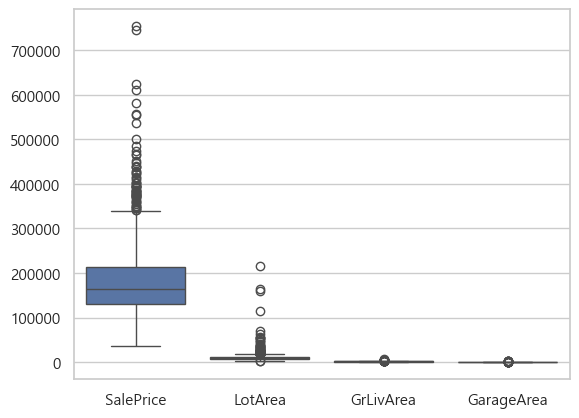

In [38]:
# TODO:
# 1) 각 컬럼별 boxplot
cols = ['SalePrice', 'LotArea', 'GrLivArea', 'GarageArea']
plt.figure()
sns.boxplot(df[cols])
plt.show()

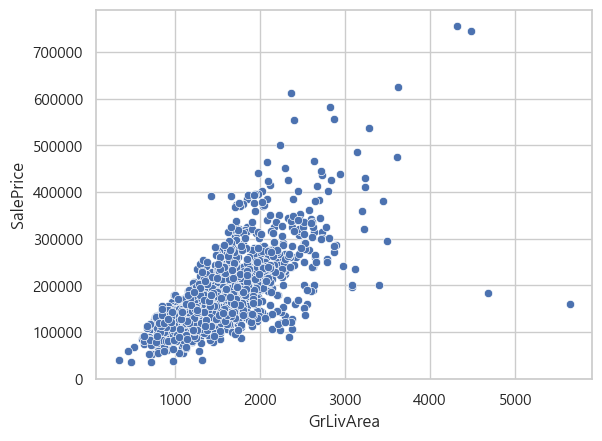

In [39]:
# 2) GrLivArea vs SalePrice 산점도
plt.figure()
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df)
plt.show()

이상치 2건 제외하고 면적이 큰 집이 가격이 높다.

## 문제 3️⃣: IQR 기반 이상값 경계 (SalePrice)
1. `SalePrice`의 Q1(25%), Q3(75%), IQR(Q3-Q1)을 구하세요.
2. IQR 방식으로 lower_bound, upper_bound를 계산하세요.
   - lower = Q1 - 1.5 * IQR
   - upper = Q3 + 1.5 * IQR
3. 이 범위를 벗어나는 행의 개수와, 전체 대비 비율(%)을 구하세요.

In [40]:
# TODO:
# Q1,Q3,IQR 계산 후 IQR 기반 하한/상한, 이상치 개수와 비율 계산
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [41]:
Q1 = df['SalePrice'].describe()['25%']
Q3 = df['SalePrice'].describe()['75%']
IQR = Q3-Q1

In [42]:
lower_bound = Q1 - 1.5 * IQR
lower_bound

np.float64(3937.5)

In [43]:
upper_bound = Q3 + 1.5 * IQR
upper_bound

np.float64(340037.5)

In [44]:
# 이상치 개수
outliers = df[(df['SalePrice'] < lower_bound) | (df['SalePrice'] > upper_bound)]
outliers

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
11,12,60,RL,85.0,11924,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,New,Partial,345000
53,54,20,RL,68.0,50271,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,385000
58,59,60,RL,66.0,13682,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,10,2006,New,Partial,438780
112,113,60,RL,77.0,9965,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,383970
151,152,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,New,Partial,372402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,1269,50,RL,NaN,14100,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,5,2008,WD,Normal,381000
1353,1354,50,RL,56.0,14720,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,410000
1373,1374,20,RL,NaN,11400,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,466500
1388,1389,20,RL,42.0,14892,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,377500


In [45]:
# 이상치 비율
outlier_count = len(outliers)
outlier_ratio = (outlier_count / len(df)) * 100
outlier_ratio

4.178082191780822

## 문제 4️⃣: 면적 관련 이상값 탐지 (GrLivArea, LotArea)
GrLivArea와 LotArea 각각에 대해:
1. Q1, Q3, IQR 계산
2. lower_bound, upper_bound 계산
3. 경계를 벗어나는 데이터 개수 출력
4. GrLivArea 이상치들만 모아서 그들의 SalePrice를 확인하고,
   '면적은 엄청 큰데 집값은 상대적으로 안 비싼' 케이스가 있는지 살펴보세요.

In [46]:
# TODO:
# GrLivArea, LotArea에 대해 IQR 이상치 개수 계산 후
# GrLivArea 이상치 샘플들의 GrLivArea, SalePrice, OverallQual, Neighborhood를 확인
print(df['GrLivArea'].describe())
print(df['LotArea'].describe())

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64
count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64


In [47]:
ga_Q1 = df['GrLivArea'].describe()['25%']
ga_Q3 = df['GrLivArea'].describe()['75%']
ga_IQR = ga_Q3 - ga_Q1

ga_lower_bound = ga_Q1 - 1.5 * ga_IQR
ga_upper_bound = ga_Q3 + 1.5 * ga_IQR

ga_outliers = df[(df['GrLivArea'] < ga_lower_bound) | (df['GrLivArea'] > ga_upper_bound)]
ga_outliers

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
58,59,60,RL,66.0,13682,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,10,2006,New,Partial,438780
118,119,60,RL,90.0,12376,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,320000
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000
197,198,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,...,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml,235000
231,232,60,RL,174.0,15138,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,403000
304,305,75,RM,87.0,18386,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,295000
324,325,80,RL,96.0,11275,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,242000
496,497,20,RL,NaN,12692,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,430000
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
583,584,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000


In [48]:
la_Q1 = df['LotArea'].describe()['25%']
la_Q3 = df['LotArea'].describe()['75%']
la_IQR = ga_Q3 - ga_Q1

la_lower_bound = la_Q1 - 1.5 * la_IQR
la_upper_bound = la_Q3 + 1.5 * la_IQR

la_outliers = df[(df['LotArea'] < la_lower_bound) | (df['LotArea'] > la_upper_bound)]
la_outliers

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
12,13,20,RL,NaN,12968,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,144000
15,16,45,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,7,2007,WD,Normal,132000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,1447,20,RL,NaN,26142,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,157900
1449,1450,180,RM,21.0,1533,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2006,WD,Abnorml,92000
1452,1453,180,RM,35.0,3675,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,145000
1453,1454,20,RL,90.0,17217,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Abnorml,84500


In [49]:
# GrLivArea 이상치들만 모아서 그들의 SalePrice를 확인하고, '면적은 엄청 큰데 집값은 상대적으로 안 비싼' 케이스가 있는지 살펴보세요.
ga_outliers[['GrLivArea', 'SalePrice']]

,GrLivArea,SalePrice
58,2945,438780
118,3222,320000
185,3608,475000
197,3112,235000
231,2794,403000
304,3493,295000
324,2978,242000
496,3228,430000
523,4676,184750
583,2775,325000


118, 197, 304, 523, 635	등 면적에 비해 가격 저렴한 집 존재

## 문제 5️⃣: 이상치 상세 살펴보기
위에서 찾은 GrLivArea 이상치들만 따로 df_outlier_area 데이터프레임으로 저장하고
해당 샘플들의 `GrLivArea`, `SalePrice`, `OverallQual`, `Neighborhood`를 출력하세요.
이 샘플들이 특정 동네에 몰려 있는지, 품질 점수(OverallQual)가 낮은데 크기만 큰 집은 있는지 서술하세요.

In [50]:
# TODO:
# df_outlier_area를 만들고 주요 컬럼만 출력하여 특징을 관찰하세요.
df_outlier_area = ga_outliers
df_outlier_area[['GrLivArea', 'SalePrice', 'OverallQual', 'Neighborhood']]

,GrLivArea,SalePrice,OverallQual,Neighborhood
58,2945,438780,10,StoneBr
118,3222,320000,7,SawyerW
185,3608,475000,10,OldTown
197,3112,235000,8,NAmes
231,2794,403000,8,NoRidge
304,3493,295000,7,OldTown
324,2978,242000,7,NAmes
496,3228,430000,8,NoRidge
523,4676,184750,10,Edwards
583,2775,325000,10,OldTown


In [51]:
df_outlier_area['Neighborhood'].value_counts()

Neighborhood
NoRidge    8
OldTown    4
StoneBr    3
NAmes      2
Edwards    2
NWAmes     2
Crawfor    2
SWISU      2
NridgHt    2
SawyerW    1
Timber     1
CollgCr    1
ClearCr    1
Name: count, dtype: int64

=> NoRidge에 많이 있음

In [52]:
df_outlier_area[df_outlier_area['OverallQual'] < 7][['GrLivArea','SalePrice','OverallQual','Neighborhood']]

,GrLivArea,SalePrice,OverallQual,Neighborhood
635,3395,200000,6,SWISU
961,2872,272000,6,NWAmes
1173,3086,200500,5,ClearCr
1328,2792,256000,6,OldTown


=> 품질점수 6이하인데 평수 높고 가격은 낮은 집 존재

## 문제 6️⃣: 이상치 처리 전략 1 - 제거(drop)
GrLivArea를 기준으로 IQR 바깥의 이상치를 제거한 새로운 DataFrame `df_clean_drop`을 만드세요.
1. 제거 전(df) vs 제거 후(df_clean_drop)의 행 수 비교
2. 두 데이터프레임 각각에서 GrLivArea의 평균, 표준편차 비교

In [53]:
# TODO:
# df_clean_drop을 만들고 행 수/평균/표준편차를 비교하세요.
df_clean_drop = df.drop(df_outlier_area.index)
df_clean_drop

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [54]:
print(len(df), df['GrLivArea'].mean(), df['GrLivArea'].median())
print(len(df_clean_drop), df_clean_drop['GrLivArea'].mean(), df_clean_drop['GrLivArea'].median())

1460 1515.463698630137 1464.0
1429 1476.7515745276417 1452.0


## 문제 7️⃣: 이상치 처리 전략 2 - 클리핑(윈저라이징)
1. GrLivArea의 IQR 기반 lower_bound~upper_bound를 이용해
   GrLivArea를 그 범위 안으로 `clip()` 한 DataFrame `df_clip`을 만드세요.
2. 원본 df와 df_clip 각각에 대해 GrLivArea의 boxplot을 나란히 그리고 비교하세요.
3. 제거(drop) 방식과 비교했을 때 클리핑의 장단점을 서술하세요.

In [60]:
print("IQR upper bound:", upper_bound)
print("GrLivArea max:", df['GrLivArea'].max())

IQR upper bound: 340037.5
GrLivArea max: 5642


In [61]:
print("IQR lower bound:", lower_bound)
print("GrLivArea min:", df['GrLivArea'].min())

IQR lower bound: 3937.5
GrLivArea min: 334


In [62]:
# TODO:
# df_clip을 만들고, 원본 vs df_clip의 GrLivArea boxplot을 비교 시각화하세요.
df_clip_ga = df['GrLivArea'].clip(lower=ga_lower_bound, upper=ga_upper_bound)
df_clip = df.copy()
df_clip['GrLivArea'] = df_clip_ga
print(df_clip['GrLivArea'])
print(df['GrLivArea'])

0       1710.0
1       1262.0
2       1786.0
3       1717.0
4       2198.0
         ...  
1455    1647.0
1456    2073.0
1457    2340.0
1458    1078.0
1459    1256.0
Name: GrLivArea, Length: 1460, dtype: float64
0       1710
1       1262
2       1786
3       1717
4       2198
        ... 
1455    1647
1456    2073
1457    2340
1458    1078
1459    1256
Name: GrLivArea, Length: 1460, dtype: int64


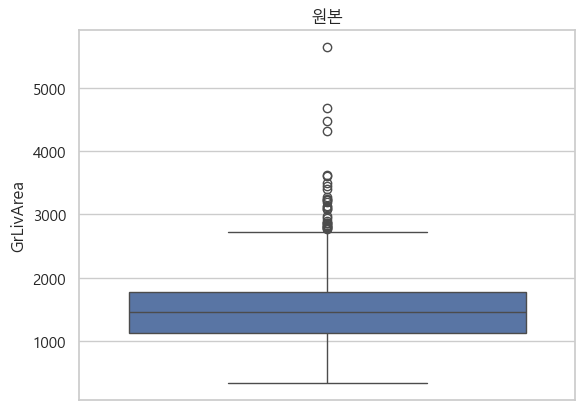

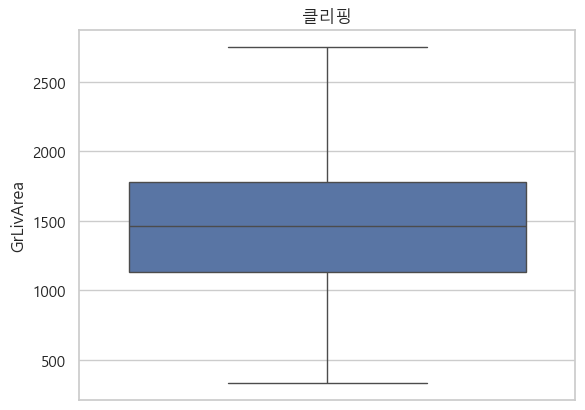

In [63]:
plt.figure()
sns.boxplot(df['GrLivArea'])
plt.title("원본")

plt.figure()
sns.boxplot(df_clip['GrLivArea'])
plt.title("클리핑")

plt.show()

## 문제 8️⃣: 이상치 처리 후 SalePrice 영향
1. 원본 df, df_clean_drop, df_clip 각각에서 SalePrice의 평균과 표준편차를 비교하세요.
2. 극단적으로 비싼 집(초고가 주택)을 어떻게 다루느냐에 따라 평균 집값이 얼마나 달라지는지 서술하세요.
3. 만약 '일반적인 중간 가격대 주택의 시세 예측'을 목표로 하는 모델이라면 어떤 버전(df / df_clean_drop / df_clip)을 쓰는 게 적절하다고 생각하나요?

In [64]:
# TODO:
# df, df_clean_drop, df_clip 각각의 SalePrice 평균/표준편차를 출력하고 해석하세요.
print("df평균: ", df['SalePrice'].mean(), "df표준편차: ", df['SalePrice'].median())
print("df_clean_drop평균: ", df_clean_drop['SalePrice'].mean(), "df_clean_drop표준편차: ", df_clean_drop['SalePrice'].median())
print("df_clip평균: ", df_clip['SalePrice'].mean(), "df_clip표준편차: ", df_clip['SalePrice'].median())

df평균:  180921.19589041095 df표준편차:  163000.0
df_clean_drop평균:  176714.08817354793 df_clean_drop표준편차:  160200.0
df_clip평균:  180921.19589041095 df_clip표준편차:  163000.0


| 처리 방법                 | 평균(SalePrice) | 표준편차    | 의미                                                     |
| --------------------- | ------------- | ------- | ------------------------------------------------------ |
| 원본(df)                | 180,921       | 163,000 | 초고가 주택 포함 → 평균이 상대적으로 높게 나옴, 표준편차도 큼                   |
| 이상치 제거(df_clean_drop) | 176,714       | 160,200 | 초고가 주택 제거 → 평균 약간 낮아지고, 표준편차 감소. “중간 가격대 집” 중심 통계 반영   |
| 클리핑(df_clip)          | 180,921       | 163,000 | clip 시도했지만 GrLivArea 이상치가 없거나 범위가 넓어 실제 변화 없음 → 평균 그대로 |


df_clean_drop <br>
초고가 이상치를 제거해서 중간 가격대 중심 모델 학습 가능. 평균과 표준편차가 현실적인 범위로 안정됨.

## 문제 9️⃣: 다변량 관점의 이상치
1. 산점도(GrLivArea vs SalePrice)를 다시 그리되,
   - GrLivArea가 IQR 상한보다 큰데
   - SalePrice는 전체 평균보다 낮은 샘플만 다른 색(예: 빨간색)으로 표시하세요.
2. 이런 집은 어떤 의미일 수 있는지 해석을 적으세요

In [65]:
# TODO:
# mask_suspicious 조건에 해당하는 점들을 빨간색으로 강조 표시한 산점도를 그리세요.
saleprice_mean = df['SalePrice'].mean()
condition = (df['GrLivArea'] > ga_upper_bound) & (df['SalePrice'] < saleprice_mean)

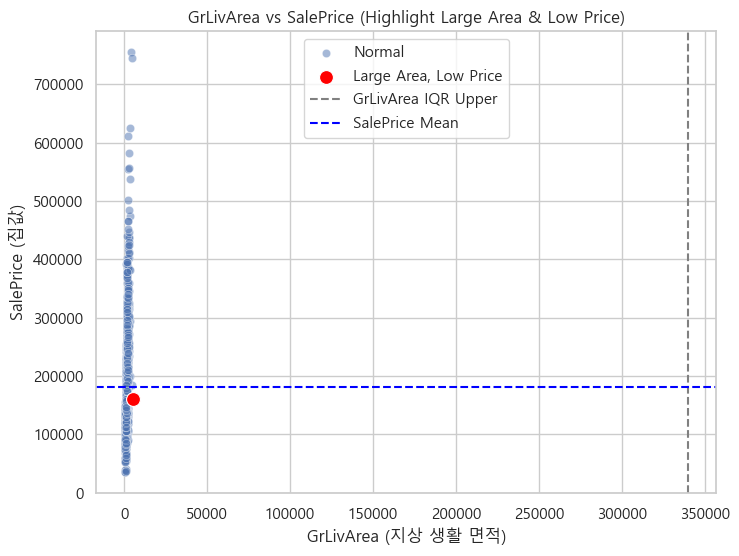

In [66]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df, alpha=0.5, label='Normal')
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df[condition], color='red', s=100, label='Large Area, Low Price')

plt.axvline(upper_bound, color='gray', linestyle='--', label='GrLivArea IQR Upper')
plt.axhline(saleprice_mean, color='blue', linestyle='--', label='SalePrice Mean')

plt.title('GrLivArea vs SalePrice (Highlight Large Area & Low Price)')
plt.xlabel('GrLivArea (지상 생활 면적)')
plt.ylabel('SalePrice (집값)')
plt.legend()
plt.show()

## 문제 🔟: 최종 의사결정 제안서 (서술형)
우리 팀이 만들 모델이 어떤 용도인지에 따라 이상치를 다루는 방식이 달라집니다.

- '일반적인 중간 가격대 주택의 시세 예측' 모델이라면 이상치를 제거하는 게 맞나요, 클리핑이 맞나요, 아니면 그대로 두나요?
- 초고가 주택까지 정확히 예측하는 모델을 만들려면 어떤 접근이 필요할까요?
- 당신의 추천 전략을 간단히 정리하세요.

* '일반적인 중간 가격대 주택의 시세 예측' 모델: 이상치 제거 적합
* '초고가 주택까지 정확히 예측' 모델: SalePrice 로그 변환